In [1]:
from pyfmi import load_fmu
import os 
import sys
import numpy as np
import pandas as pd
from pylab import *
from time import sleep
import seaborn as sn
from utils import Battery, SolarPanel
import calendar 
from datetime import timedelta, date
import logging
import math
import gym
from gym import spaces
from gym.utils import seeding



import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam



%matplotlib inline

plt.rcParams["figure.figsize"] = (15,5)

print(__doc__)

Using TensorFlow backend.


Automatically created module for IPython interactive environment


In [ ]:
filename = 'small_office'
model = load_fmu(filename + '.fmu', log_file_name='log_file.txt', kind='auto')

In [ ]:
data = pd.DataFrame()
battery = Battery(capacity=5000)
solar = SolarPanel(area=50, f_active=0.90,
                   eta_cell=0.9, eta_inv=0.9)

day = 1
for ii, i in enumerate(range(152, 160)):
    length = timeStop = 86400
    numSteps = timeStop/6
    numSteps = 144
    opts = model.simulate_options()
    opts['ncp'] = numSteps
    t = np.linspace(i*length, (i+1) * timeStop,numSteps + 1, dtype=np.int64)
    day += 1
    
    start_time = i*86400
    final_time=(i+1)*86400
    
    battery_action = np.random.choice([-2000, 2000], 144)
    battery_action = np.insert(battery_action, 0,0)
    battery_flag = battery.step(battery_action)
    
    # energyplus model input
    avail_manager_action = np.random.randint(0, 2, 144)
    avail_manager_action = np.insert(avail_manager_action, 0, 0)
    ut = np.transpose(np.vstack((t, np.repeat(avail_manager_action, 1))))
    input_object = ('Q', ut)
    
    res = model.simulate(start_time=start_time, final_time=final_time, input=input_object, options=opts)
    
    #reading data from csv file
#     sleep(1)
#     df = pd.read_csv('Output_EPExport_Slave/' + filename + '.csv', index_col='Date/Time')
    df = pd.DataFrame({})
    for key in model.get_model_variables().keys():
        df[key] = res[key]
    df['managerAction'] = avail_manager_action
    df[battery.id] = battery.get_history()['state'][ii*numSteps: (ii+1)*numSteps + 1]
    df['charge_discharge'] = battery.get_history()['current'][ii*numSteps: (ii+1)*numSteps + 1]
    df['solar_generation'] = solar.step(res['directSolarRad'])
    df['substation_electiricty'] = res['totalDemand'] - df['charge_discharge'] - df['solar_generation']
    df.index = pd.DatetimeIndex(pd.date_range('6/' + str(day) + '/2017', periods=145, freq='10min'))

    data = data.append(df)


In [ ]:
data.columns

In [2]:
logger = logging.getLogger(__name__)
"""
EnergyPlus FMU model for co-simulation.
"""

class EP(gym.Env):
    
    reward_range = (-np.inf, np.inf)
    action_space = None
    observation_space = None
    
    def __init__(self, 
                 energy_plus_file,
                 solar_panel_area=50,
                 solar_panel_percent_active=0.9,
                 solar_panel_efficiency=0.9,
                 inverter_efficiency=0.9,
                 battery_discharge_efficiency=0.9,
                 battery_charge_efficiency=0.9,
                 battery_capacity=5000,
                 simulation_length=10):
        
        self.model = load_fmu(energy_plus_file, 
                              log_file_name='log_file.txt',
                              kind='auto')
        
        
        self.sim_duration = 86400
        self.numSteps = 144
        self.opts = self.model.simulate_options()
        self.opts['ncp'] = self.numSteps
        
        self.battery = Battery(capacity=battery_capacity,
                          charge_efficiency=battery_charge_efficiency,
                          discharge_efficiency=battery_discharge_efficiency)
        self.solar = SolarPanel(area=solar_panel_area,
                           f_active=solar_panel_percent_active,
                           eta_cell=solar_panel_efficiency,
                           eta_inv=inverter_efficiency)
        self._seed()
        self.action_space = None
        self.state = None
        self.observation_space = None
        self.date =  datetime.date(2017, 6, 1)
        self.counter = 0
        self.store = pd.DataFrame({})
        self.time = self.model.time
        

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    
    def _step(self, action):
#         assert self.action_space.contains(action), "%r (%s) invalid"%(action, type(action))
        state = self.state
        
        start_time = self.counter * self.sim_duration
        final_time = (self.counter + 1) * self.sim_duration
        
        t = np.linspace(start_time,
                        final_time,
                        self.numSteps + 1, 
                        dtype=np.int64)



        battery_action = action # replace with action 
        battery_flag = self.battery.step(battery_action)

#         avail_manager_action = action[:, 1]  # skipping the HVAC control for now
        avail_manager_action = np.random.randint(1, 2, 145)
        
        ut = np.transpose(np.vstack((t, np.repeat(avail_manager_action, 1))))
        input_object = ('Q', ut)

        res = self.model.simulate(start_time=start_time, 
                             final_time=final_time,
                             input=input_object,
                             options=self.opts)
        self.time = self.model.time


        df = pd.DataFrame({})
        for key in self.model.get_model_variables().keys():
            df[key] = res[key]
            
        df['managerAction'] = avail_manager_action 
        
        
        df[self.battery.id] = self.battery.get_history()['state'][self.counter * self.numSteps: 
                                                        (self.counter + 1) * self.numSteps + 1]
        df['charge_discharge'] = self.battery.get_history()['current'][self.counter * self.numSteps: 
                                                        (self.counter + 1) * self.numSteps + 1]
        df['solar_generation'] = self.solar.step(res['directSolarRad'])
        df['substation_electiricty'] = res['totalDemand'] - df['charge_discharge'] - df['solar_generation']
        df.index = pd.DatetimeIndex(pd.date_range(str(self.date.month) + '/' + str(self.date.day) + '/' +
                                                  str(self.date.year), periods=145, freq='10min'))

        self.store = self.store.append(df)
        self.date = self.date + datetime.timedelta(days=1)
        
        self.state = df[['outdoorDbTemp', 'solar_generation', 
                         self.battery.id, 'totalDemand']]
        
        #updating the counter
        self.counter += 1
        
        reward = - np.clip(df['substation_electiricty'], -1, 1)
        done = np.zeros(reward.shape[0]) > 1
        done[-1] = True
        
        return self.state.values, reward, done
    
    def _reset(self):
        self.state = np.random.uniform(low=-0.05, high=0.05,
                                      size=(145, 4))
        return np.array(self.state)
    
    def _close(self):
        self.model.terminate()


    
    
class Space(object):
    """Defines the observation and action spaces, so you can write generic
    code that applies to any Env. For example, you can choose a random
    action.
    """

    def sample(self):
        """
        Uniformly randomly sample a random element of this space
        """
        self.state = np.random.uniform(low=-0.05, high=0.05,
                                      size=(145, 4))
        return np.array(self.state)

    def contains(self, x):
        """
        Return boolean specifying if x is a valid
        member of this space
        """
        return True

    def to_jsonable(self, sample_n):
        """Convert a batch of samples from this space to a JSONable data type."""
        # By default, assume identity is JSONable
        return sample_n

    def from_jsonable(self, sample_n):
        """Convert a JSONable data type to a batch of samples from this space."""
        # By default, assume identity is JSONable
        return sample_n


In [ ]:
import numpy as np
import gym

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model

from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

# create seperate inputs

In [ ]:
solar_input = Input(shape=(145,), dtype='float32', 
                    name='solar_input')

x = Embedding(output_dim=512, input_dim=145,
              input_length=1)(solar_input)

solar_lstm_out = LSTM(32)(x)


batt_input = Input(shape=(145,), dtype='float32', 
                    name='batt_input')
x = Embedding(output_dim=512, input_dim=145,
              input_length=1)(batt_input)

batt_lstm_out = LSTM(32)(x)



temp_input = Input(shape=(145,), dtype='float32', 
                    name='temp_input')

x = Embedding(output_dim=512, input_dim=145,
              input_length=1)(temp_input)

temp_lstm_out = LSTM(32)(x)



demand_input = Input(shape=(145,), dtype='float32', 
                    name='demand_input')
x = Embedding(output_dim=512, input_dim=145,
              input_length=1)(demand_input)

demand_lstm_out = LSTM(32)(x)


# concatinating the LSTM outputs

In [ ]:
x = keras.layers.concatenate([solar_lstm_out,
                             batt_lstm_out,
                             temp_lstm_out,
                             demand_lstm_out])

# Stack dense layers

In [ ]:
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

# Defining two outputs for each action

In [ ]:
batt_output = Dense(1, activation='sigmoid', name='batt_output')(x)
hvac_output = Dense(1, activation='sigmoid', name='hvac_output')(x)

# defining the model

In [ ]:
model = Model(inputs=[solar_input, batt_input,
                      temp_input, demand_input],
              outputs=[batt_output, hvac_output])
#                 outputs=[batt_output])

# setting up dqn

In [ ]:
memory = SequentialMemory(limit=50000, window_length=1)
policy = BoltzmannQPolicy()

In [ ]:
dqn = DQNAgent(model=model, nb_actions=145,
               memory=memory, nb_steps_warmup=10,
               enable_dueling_network=True, 
               dueling_type='avg', target_model_update=1e-2, 
               policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [3]:
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# DDQN with discretized action space

In [4]:
class DDQNAgent(object):
    """
    Deep Q-Learning agent implementation.
    """
    
    
    def __init__(self, state_size, action_size, 
                 memory_lenght, discount):
        
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=memory_lenght)
        self.gamma = discount
        self.epsilon = 0.97
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.01
        self.network = self._build_network()
        self.target_network = self._build_network()
        self.update_target_network()
        
    
    def _build_network(self):
        """
        build neural network for Deep Q-learning model.
        """
        
        network = Sequential()
        network.add(Dense(256, input_dim=self.state_size,
                         activation='relu'))
        network.add(Dense(256, activation='relu'))
        network.add(Dense(64, activation='relu'))
        network.add(Dense(self.action_size, activation='linear'))
        network.compile(loss='mse',
                       optimizer=Adam(lr=self.learning_rate))
        return network

    def update_target_network(self):
        # copy weights from model to target_model
        self.target_network.set_weights(self.network.get_weights())
        
    def remember(self, state, action, reward, next_state, done):
        for mem in zip(state, action, reward, next_state, done):
            self.memory.append(mem)

    
    def act(self, states):
        actions = []
        for state in states:
            if np.random.rand() <= self.epsilon:
                actions.append(random.randrange(self.action_size))
            action_value = self.network.predict(state.reshape((1,4)))
            actions.append(np.argmax(action_value))
        return actions
    
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = self.network.predict(state.reshape((1, 4)))
            if done:
                target[0][action] = reward
            else:
                a = self.network.predict(next_state.reshape((1, 4)))[0]
                t = self.target_network.predict(next_state.reshape((1, 4)))[0]
                target[0][action] = reward + self.gamma * t[np.argmax(a)]
            self.network.fit(state.reshape((1,4)), target, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        
    def load(self, name):
        self.network.load_weights(name)

    def save(self, name):
        self.network.save_weights(name)   

In [5]:
if __name__ == "__main__":
    
    env = EP('small_office.fmu')
    state_size = 4
    action_size = 9
    agent = DDQNAgent(state_size, action_size, 2000, 0.99)
    done = False
    batch_size = 32
    
    

    for e in range(10):
        states = env.reset()
        states = np.reshape(states, [states.shape[0], state_size])
        for time in range(10):
            actions = agent.act(states)
            next_state, reward, done = env.step(actions)
            next_state = np.reshape(next_state, [next_state.shape[0], state_size])
            agent.remember(states, actions, reward, next_state, done)
            states = next_state
#             if done:
#                 print("episode: {}/{}, score: {}, e: {:.2}"
#                       .format(e, EPISODES, time, agent.epsilon))
#                 break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
        # if e % 10 == 0:
        #     agent.save("./save/cartpole.h5")

Simulation interval    : 0 - 86400.0 seconds.
Elapsed simulation time: 0.0506520271301 seconds.
Simulation interval    : 86400 - 172800.0 seconds.
Elapsed simulation time: 0.0606489181519 seconds.
Simulation interval    : 172800 - 259200.0 seconds.
Elapsed simulation time: 0.0488770008087 seconds.
Simulation interval    : 259200 - 345600.0 seconds.
Elapsed simulation time: 0.0578870773315 seconds.
Simulation interval    : 345600 - 432000.0 seconds.
Elapsed simulation time: 0.0540511608124 seconds.
Simulation interval    : 432000 - 518400.0 seconds.
Elapsed simulation time: 0.0635290145874 seconds.
Simulation interval    : 518400 - 604800.0 seconds.
Elapsed simulation time: 0.0631439685822 seconds.
Simulation interval    : 604800 - 691200.0 seconds.
Elapsed simulation time: 0.0624771118164 seconds.
Simulation interval    : 691200 - 777600.0 seconds.
Elapsed simulation time: 0.0710849761963 seconds.
Simulation interval    : 777600 - 864000.0 seconds.
Elapsed simulation time: 0.0669739246

Simulation interval    : 6912000 - 6998400.0 seconds.
Elapsed simulation time: 0.0537829399109 seconds.
Simulation interval    : 6998400 - 7084800.0 seconds.
Elapsed simulation time: 0.0617990493774 seconds.
Simulation interval    : 7084800 - 7171200.0 seconds.
Elapsed simulation time: 0.0572838783264 seconds.
Simulation interval    : 7171200 - 7257600.0 seconds.
Elapsed simulation time: 0.0576369762421 seconds.
Simulation interval    : 7257600 - 7344000.0 seconds.
Elapsed simulation time: 0.0588839054108 seconds.
Simulation interval    : 7344000 - 7430400.0 seconds.
Elapsed simulation time: 0.0651049613953 seconds.
Simulation interval    : 7430400 - 7516800.0 seconds.
Elapsed simulation time: 0.0661599636078 seconds.
Simulation interval    : 7516800 - 7603200.0 seconds.
Elapsed simulation time: 0.0634608268738 seconds.
Simulation interval    : 7603200 - 7689600.0 seconds.
Elapsed simulation time: 0.0548839569092 seconds.
Simulation interval    : 7689600 - 7776000.0 seconds.
Elapsed si

/home/mfc/.virtualenvs/research/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
.resample() is now a deferred operation
You called plot(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
  """Entry point for launching an IPython kernel.


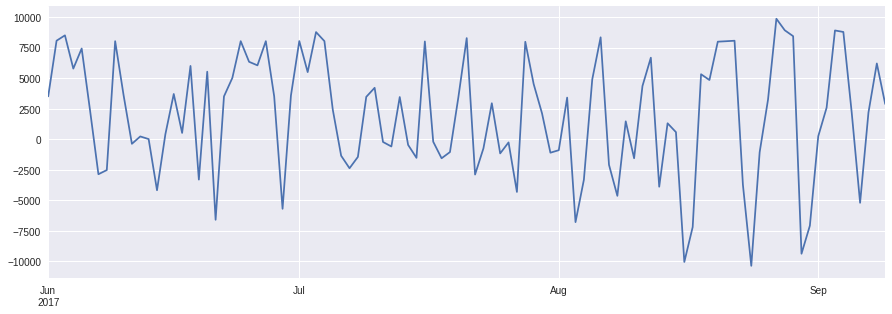

In [10]:
env.store.substation_electiricty.resample('24H').plot()

In [11]:
env.store.columns

Index([u'zs2Temp', u'outdoorRelHumidity', u'outdorWbTemp', u'nonHvacDemand',
       u'Q', u'directSolarRad', u'flag', u'hvacDemand', u'diffuseSolarRad',
       u'totalDemand', u'outdoorDbTemp', u'zn2Temp', u'managerAction',
       u'battery_0', u'charge_discharge', u'solar_generation',
       u'substation_electiricty'],
      dtype='object')

In [6]:
a = EP('./small_office.fmu')
a.date

datetime.date(2017, 6, 1)